In [10]:
"""Probar Partially Observable Markov Model (POMM) de Katahira K. et al. (2013)"""

'Probar Partially Observable Markov Model (POMM) de Katahira K. et al. (2013)'

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
import config_dodo
import config
from utilities import read_pickle, write_pickle
import pomegranate as pg
import string

(config_dodo.FIG_PATH / "Transitions").mkdir(parents=True, exist_ok=True)
sns.set_context("paper", font_scale=2.0)
sns.set_style(
    "ticks",
    {
        "text.color": "k",
        "axes.edgecolor": "k",
        "axes.labelcolor": "k",
        "xtick.color": "k",
        "ytick.color": "k",
    },
)

In [12]:
out_stp_all = read_pickle(config_dodo.OUT_PATH / "out_stp_all.pickle")
out_wav_all = read_pickle(config_dodo.OUT_PATH / "out_wav_all.pickle")

In [13]:
long_data = read_pickle(config_dodo.LAB_PATH / "label_long_data.pickle")
long_data

,mouse,day,trial,local_idx,global_idx,label_stp,label_wav,sequence_group_stp,sequence_group_wav
0,262,1,1,0,0,10,9,1,1
1,262,1,1,1,1,10,9,1,1
2,262,1,1,2,2,10,9,1,1
3,262,1,1,3,3,10,9,1,1
4,262,1,1,4,4,10,9,1,1
...,...,...,...,...,...,...,...,...,...
5458547,330,5,5,21412,5458547,5,3,103851,10213
5458548,330,5,5,21413,5458548,5,3,103851,10213
5458549,330,5,5,21414,5458549,5,3,103851,10213
5458550,330,5,5,21415,5458550,5,3,103851,10213


In [14]:
seq_data_stp = read_pickle(config_dodo.LAB_PATH / "label_sequence_data_stp.pickle")
seq_data_stp

,mouse,day,trial,label_stp,sequence_group_stp,duration,log_duration,local_idx,global_idx
0,262,1,1,10,1,19,1.278754,0,0
1,262,1,1,8,2,2,0.301030,19,19
2,262,1,1,10,3,157,2.195900,21,21
3,262,1,1,8,4,8,0.903090,178,178
4,262,1,1,9,5,10,1.000000,186,186
...,...,...,...,...,...,...,...,...,...
103846,330,5,5,5,103847,3,0.477121,21288,5458423
103847,330,5,5,6,103848,6,0.778151,21291,5458426
103848,330,5,5,5,103849,10,1.000000,21297,5458432
103849,330,5,5,1,103850,1,0.000000,21307,5458442


In [15]:
seq_data_wav = read_pickle(config_dodo.LAB_PATH / "label_sequence_data_wav.pickle")
seq_data_wav

,mouse,day,trial,label_wav,sequence_group_wav,duration,log_duration,local_idx,global_idx
0,262,1,1,9,1,1333,3.124830,0,0
1,262,1,1,3,2,349,2.542825,1333,1333
2,262,1,1,7,3,42,1.623249,1682,1682
3,262,1,1,10,4,1358,3.132900,1724,1724
4,262,1,1,7,5,889,2.948902,3082,3082
...,...,...,...,...,...,...,...,...,...
10208,330,5,5,5,10209,8,0.903090,20450,5457585
10209,330,5,5,4,10210,227,2.356026,20458,5457593
10210,330,5,5,5,10211,140,2.146128,20685,5457820
10211,330,5,5,2,10212,411,2.613842,20825,5457960


In [16]:
sequences_stp = np.array([
    ls[1].to_list() for ls in seq_data_stp.groupby(["mouse", "day", "trial"])["label_stp"]
], dtype=object)
sequences_wav = np.array([
    ls[1].to_list() for ls in seq_data_wav.groupby(["mouse", "day", "trial"])["label_wav"]
], dtype=object)
model_stp = pg.MarkovChain.from_samples(sequences_stp)
model_wav = pg.MarkovChain.from_samples(sequences_wav)

In [17]:
trans_stp = pd.DataFrame(model_stp.distributions[1].parameters[0], columns=["from", "to", "prob"]).set_index(["from", "to"])["prob"].unstack().reset_index(drop=True)
trans_stp.columns = trans_stp.columns.tolist()
trans_wav = pd.DataFrame(model_wav.distributions[1].parameters[0], columns=["from", "to", "prob"]).set_index(["from", "to"])["prob"].unstack().reset_index(drop=True)
trans_wav.columns = trans_wav.columns.tolist()
mat_stp = np.array(trans_stp.to_numpy(), dtype=float)
mat_wav = np.array(trans_wav.to_numpy(), dtype=float)

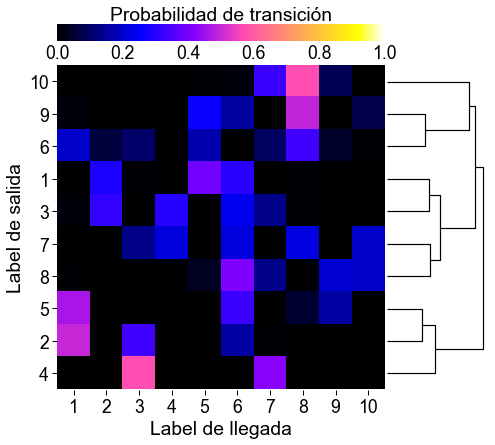

In [18]:
import scipy.cluster.hierarchy as spc
import scipy.spatial.distance as spd
from scipy.spatial import distance_matrix

left, width_im = 0.0, 0.65
bottom, height_im = 0.0, 0.95
width_dendro, height_dendro = 0.2, 0.75
spacing = 0.005

rect_im = [left, bottom, width_im, height_im]
rect_dendro = [left + width_im + spacing, bottom, width_dendro, height_dendro]

# fig = plt.figure(figsize=(8, 7))
fig = plt.figure(figsize=(7, 6))

ax_im = fig.add_axes(rect_im, frameon=False)
ax_dendro = fig.add_axes(rect_dendro, frameon=False)

dist_matrix = distance_matrix(mat_stp, mat_stp)
pdist = spd.pdist(dist_matrix)
link = spc.linkage(pdist, method="ward", optimal_ordering=True)
with plt.rc_context({"lines.linewidth": 1.2}):
    dendro = spc.dendrogram(link, color_threshold=1.0, orientation="right", no_labels=True, link_color_func=lambda x: "k", ax=ax_dendro)
ax_dendro.set_xticks([])

sort_idx = np.array(dendro["leaves"])
# im = ax_im.imshow(mat_stp[sort_idx], aspect="auto", cmap="binary", vmin=0, vmax=1)
im = ax_im.imshow(mat_stp[sort_idx], aspect="auto", cmap="gnuplot2", vmin=0, vmax=1)
cax = plt.colorbar(im, ax=ax_im, orientation="horizontal", location="top", pad=0.06)
cax.set_label("Probabilidad de transición")
cax.ax.xaxis.set_ticks_position("bottom")
cax.ax.set_frame_on(False)
cax.ax.tick_params(axis="both", which="both", length=0)
ax_im.set_xticks(range(10))
ax_im.set_xticklabels(range(1, 11))
ax_im.set_yticks(range(10))
ax_im.set_yticklabels(sort_idx + 1)
ax_im.set_ylabel("Label de salida")
ax_im.set_xlabel("Label de llegada")
plt.show()
plt.close()

In [19]:
def search_sequence_numpy(arr, seq, k=1):
    """Find sequence in an array, and return the kth next value since the match."""
    arr = np.array(arr)
    seq = np.array(seq)
    len_arr = len(arr)
    len_seq = len(seq)
    if len_seq > len_arr:
        idx =  []
    if len_seq == 0:
        idx =  []
    if len_seq == 1:
        idx = np.where(arr == seq[0])[0]
    if len_seq == 2:
        idx = np.where(np.logical_and(arr[: -1] == seq[0], arr[1: ] == seq[1]))[0]
    else:
        raise ValueError("Sequence length should be less than 3.")
    if len(idx) == 0:
        return []
    else:
        idx = idx[idx + len_seq - 1 + k < len_arr]
        idx += len_seq - 1 + k
        return arr[idx]

In [20]:
observed_stp = []
expected_stp = []
sample_sizes_stp = []
for l in range(1, 11):
    l_prev = np.argmax(mat_stp[:, l - 1]) + 1
    condition = np.array([l_prev, l])
    cond_sequences = np.array([
        search_sequence_numpy(arr=sequences_stp[i], seq=condition) for i in range(len(sequences_stp))
    ], dtype=object)
    keep_idx = np.vectorize(lambda x: len(x) > 0)(cond_sequences)
    cond_sequences = cond_sequences[keep_idx]
    cond_model = pg.MarkovChain.from_samples(cond_sequences)
    cond_trans = pd.DataFrame(cond_model.distributions[1].parameters[0], columns=["from", "to", "prob"]).set_index(["from", "to"])["prob"].unstack().reset_index(drop=True)
    cond_trans.columns = cond_trans.columns.tolist()
    cond_trans = (trans_stp * 0 + cond_trans).fillna(0)
    cond_mat = np.array(cond_trans.to_numpy(), dtype=float)
    observed_stp.append(cond_mat[l - 1, list(range(l - 1)) + list(range(l, 10))])
    expected_stp.append(mat_stp[l - 1, list(range(l - 1)) + list(range(l, 10))])
    sample_sizes_stp.append(len(np.concatenate(cond_sequences)))
observed_stp = np.array(observed_stp)
expected_stp = np.array(expected_stp)
sample_sizes_stp = np.array(sample_sizes_stp)

In [21]:
observed_wav = []
expected_wav = []
sample_sizes_wav = []
for l in range(1, 11):
    l_prev = np.argmax(mat_wav[:, l - 1]) + 1
    condition = np.array([l_prev, l])
    cond_sequences = np.array([
        search_sequence_numpy(arr=sequences_wav[i], seq=condition) for i in range(len(sequences_wav))
    ], dtype=object)
    keep_idx = np.vectorize(lambda x: len(x) > 0)(cond_sequences)
    cond_sequences = cond_sequences[keep_idx]
    cond_model = pg.MarkovChain.from_samples(cond_sequences)
    cond_trans = pd.DataFrame(cond_model.distributions[1].parameters[0], columns=["from", "to", "prob"]).set_index(["from", "to"])["prob"].unstack().reset_index(drop=True)
    cond_trans.columns = cond_trans.columns.tolist()
    cond_trans = (trans_wav * 0 + cond_trans).fillna(0)
    cond_mat = np.array(cond_trans.to_numpy(), dtype=float)
    observed_wav.append(cond_mat[l - 1, list(range(l - 1)) + list(range(l, 10))])
    expected_wav.append(mat_wav[l - 1, list(range(l - 1)) + list(range(l, 10))])
    sample_sizes_wav.append(len(np.concatenate(cond_sequences)))
observed_wav = np.array(observed_wav)
expected_wav = np.array(expected_wav)
sample_sizes_wav = np.array(sample_sizes_wav)

In [22]:
from scipy.stats import chisquare

res_stp = chisquare(observed_stp * sample_sizes_stp[:, np.newaxis], expected_stp * sample_sizes_stp[:, np.newaxis] + 1, axis=1)
print(res_stp)
print(res_stp.pvalue < 0.05 / 9)

res_wav = chisquare(observed_wav * sample_sizes_wav[:, np.newaxis], expected_wav * sample_sizes_wav[:, np.newaxis] + 1, axis=1)
print(res_wav)
print(res_wav.pvalue < 0.05 / 9)

Power_divergenceResult(statistic=array([6474.13491081, 1575.85329158, 3433.56854239,   18.07329315,
       5809.35517961, 3162.6009042 , 1567.40282898, 2380.7167191 ,
       3354.        , 1828.        ]), pvalue=array([0.        , 0.        , 0.        , 0.02068366, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]))
[ True  True  True False  True  True  True  True  True  True]
Power_divergenceResult(statistic=array([ 20.0201979 , 101.75519628,  59.72178853, 370.        ,
       657.48570214, 358.        , 369.        , 293.        ,
       223.        , 281.        ]), pvalue=array([1.02599049e-002, 1.86817804e-018, 5.28503638e-010, 4.85228413e-075,
       1.01200053e-136, 1.77416646e-072, 7.93572442e-075, 1.27099360e-058,
       8.94489252e-044, 4.52698166e-056]))
[False  True  True  True  True  True  True  True  True  True]


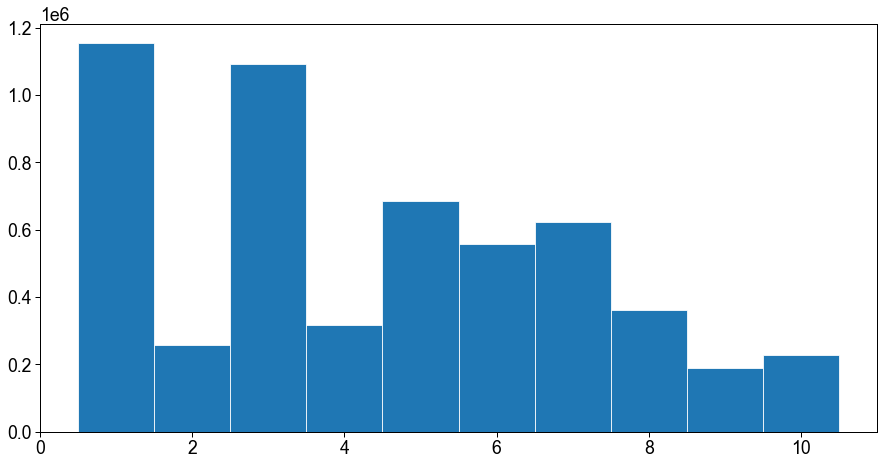

In [23]:
plt.figure(figsize=(15, 7.5))
plt.hist(long_data["label_stp"], bins=np.arange(0.5, 11.5)) # labels
plt.show()
plt.close()

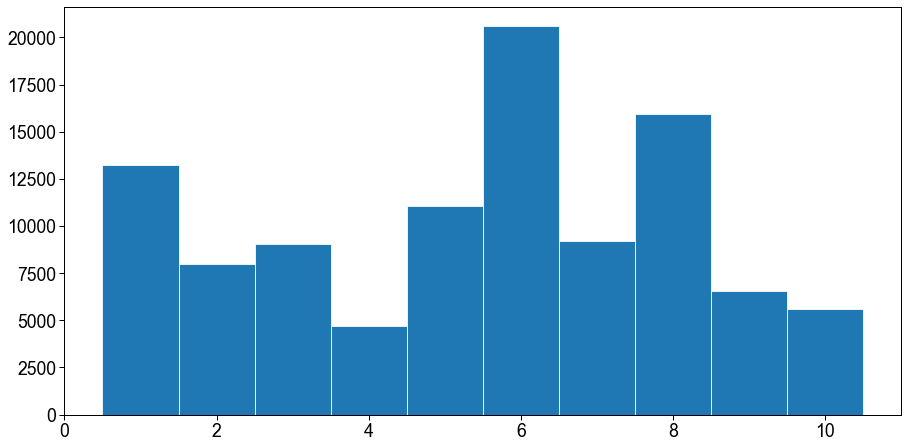

In [24]:
plt.figure(figsize=(15, 7.5))
plt.hist(seq_data_stp["label_stp"], bins=np.arange(0.5, 11.5)) # labels
plt.show()
plt.close()

In [25]:
# stp_sequences = np.array([
#     ls[1].to_numpy() for ls in long_data.groupby(["mouse", "day", "trial"])["label_stp"]
# ], dtype=object)
# wav_sequences = np.array([
#     ls[1].to_numpy() for ls in long_data.groupby(["mouse", "day", "trial"])["label_wav"]
# ], dtype=object)
stp_sequences = np.array([
    ls[1].to_numpy() for ls in seq_data_stp.groupby(["mouse", "day", "trial"])["label_stp"]
], dtype=object)
wav_sequences = np.array([
    long_data.iloc[idx[1].to_numpy()]["label_wav"].to_numpy() for idx in seq_data_stp.groupby(["mouse", "day", "trial"])["global_idx"]
], dtype=object)

In [26]:
cond_probs = []
cond_sample_sizes = []
for l in range(1, 11):
    cond_l = [stp[wav == l] for stp, wav in zip(stp_sequences, wav_sequences)]
    cond_l = np.concatenate(cond_l)
    _, counts = np.unique(cond_l, return_counts=True)
    cond_probs.append(counts / len(cond_l))
    cond_sample_sizes.append(len(cond_l))
cond_probs = np.array(cond_probs)
cond_sample_sizes = np.array(cond_sample_sizes)

_, counts = np.unique(seq_data_stp["label_stp"], return_counts=True)
marginal = counts / len(seq_data_stp)

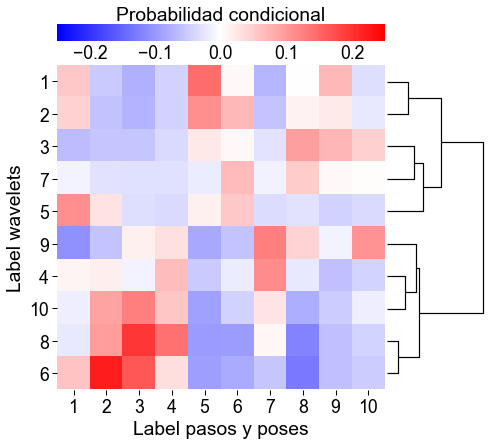

In [27]:
import scipy.cluster.hierarchy as spc
import scipy.spatial.distance as spd
from scipy.spatial import distance_matrix

left, width_im = 0.0, 0.65
bottom, height_im = 0.0, 0.95
width_dendro, height_dendro = 0.2, 0.75
spacing = 0.005

rect_im = [left, bottom, width_im, height_im]
rect_dendro = [left + width_im + spacing, bottom, width_dendro, height_dendro]

fig = plt.figure(figsize=(7, 6))

ax_im = fig.add_axes(rect_im, frameon=False)
ax_dendro = fig.add_axes(rect_dendro, frameon=False)

dist_matrix = distance_matrix(cond_probs, cond_probs)
pdist = spd.pdist(dist_matrix)
link = spc.linkage(pdist, method="ward", optimal_ordering=True)
with plt.rc_context({"lines.linewidth": 1.2}):
    dendro = spc.dendrogram(link, color_threshold=1.0, orientation="right", no_labels=True, link_color_func=lambda x: "k", ax=ax_dendro)
ax_dendro.set_xticks([])

sort_idx = np.array(dendro["leaves"])
im = ax_im.imshow(cond_probs[sort_idx] - marginal, aspect="auto", cmap="bwr", vmin=-0.25, vmax=0.25)
# im = ax_im.imshow(cond_probs[sort_idx], aspect="auto", cmap="gnuplot2", vmin=0, vmax=1)
cax = plt.colorbar(im, ax=ax_im, orientation="horizontal", location="top", pad=0.06)
cax.set_label("Probabilidad condicional")
cax.ax.xaxis.set_ticks_position("bottom")
cax.ax.set_frame_on(False)
cax.ax.tick_params(axis="both", which="both", length=0)
ax_im.set_xticks(range(10))
ax_im.set_xticklabels(range(1, 11))
ax_im.set_yticks(range(10))
ax_im.set_yticklabels(sort_idx + 1)
ax_im.set_xlabel("Label pasos y poses")
ax_im.set_ylabel("Label wavelets")
plt.show()
plt.close()

In [28]:
from scipy.stats import chisquare

res = chisquare(f_obs=cond_probs * cond_sample_sizes, f_exp=marginal * cond_sample_sizes, axis=1)
print(res)
print(cond_sample_sizes)

"""When using different sample sizes, use the smallest sample size."""
"""The larger sample size acts as a reference."""
"""https://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm"""
"""https://stats.stackexchange.com/questions/420193/chi-square-test-between-samples-with-very-different-size"""
"""La H_0 del chi squared goodness of fit es que tienen la misma distribución"""
"""Como obtuvimos p-valores < 0.05, rechazamos la H_0"""

Power_divergenceResult(statistic=array([ 5478.49693309,  3750.40568514,  3592.58807123,  3863.98055787,
        2695.65022697, 17386.15854145,   785.7773221 , 14474.15919648,
        6702.50083482,  6339.40428276]), pvalue=array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.44792273e-163, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000]))
[12209 14814 14030  8980  7792  7882 11564  4239 13290  9051]


'Como obtuvimos p-valores < 0.05, rechazamos la H_0'

In [29]:
(config_dodo.LAB_PATH / "HMM").mkdir(exist_ok=True)
# write_pickle(model, config_dodo.LAB_PATH / "HMM/hmm_model_baked_unfit_stp_wav_sequence.pickle")

In [40]:
import networkx as nx
from itertools import product
from matplotlib import cm
import matplotlib.patheffects as PathEffects
from string import ascii_lowercase

def annotate_labels_trans(ax, unique_labels, labels, outcomes):
    """
    Annotates labels to a UMAP segmented embedding
    Parameters
    ----------
    ax: plt.axes
            Axes to annotate labels on
    unique_labels: array_like
            Unique label values
    labels: array_like
            Labels associated to the UMAP outcomes
    outcomes: array_like
            UMAP outcomes, the annotations will be displayed in their centroids
    """
    for i in unique_labels:
        label_median = np.median(outcomes[labels == i], axis=0)
        label_txt = ax.text(
            label_median[0],
            label_median[1],
            str(i),
            fontsize=25,
            color="1",
            horizontalalignment="center",
            verticalalignment="center",
        )
        label_txt.set_path_effects(
            [
                PathEffects.Stroke(
                    linewidth=1,
                    foreground="1",
                ),
                PathEffects.Normal(),
            ]
        )

def plot_transition_graph(
        matrix, sequence, labels, unique_labels, N, outcomes,
        pos_legend_frame, pos_ini, offset_ini, pos_fin, offset_fin, weight_factor=10, save_name=False,
    ):
    """
    Plots transition graph
    """
    plt.figure(figsize=(7, 7))
    _, probability = np.unique(np.concatenate(sequence), return_counts=True)
    probability = probability / len(np.concatenate(sequence))
    G = nx.DiGraph()
    G.add_nodes_from(labels - 1)

    G.add_weighted_edges_from([
        (i, j, matrix[i, j]) for i, j in product(range(N), range(N)) if matrix[i, j] > 1 / (N - 1)
    ])

    colors = {
        i: cm.tab10(i / (N - 1))[:3]
        for i in range(N)
    }

    heavy_edges = [
        (u, v) for (u, v, d) in G.edges(data=True) if probability[u] > 1 / N
    ]
    heavy_edge_weights = [
        G[u][v]["weight"] * weight_factor for u, v in G.edges() if probability[u] > 1 / N
    ]
    light_edges = [
        (u, v) for (u, v, d) in G.edges(data=True) if probability[u] <= 1 / N
    ]
    light_edge_weights = [
        G[u][v]["weight"] * weight_factor for u, v in G.edges() if probability[u] <= 1 / N
    ]
    pos = {i: np.median(outcomes[labels == i + 1], axis=0) + (0, 0.25) for i in range(N)}
    
    G_meta = nx.DiGraph()
    G_meta.add_nodes_from(labels - 1)
    G_meta.add_nodes_from(["ini", "fin"])
    num_ini_fin = 5
    inis = np.concatenate([seq[:num_ini_fin] for seq in sequence])
    lab_ini, prob_ini = np.unique(inis, return_counts=True)
    prob_ini = prob_ini / len(inis)
    prob_ini = dict(zip(lab_ini, prob_ini))
    G_meta.add_weighted_edges_from([
        ("ini", l - 1, p * weight_factor) for l, p in prob_ini.items() if np.round(p, 2) >= 1 / N
    ])
    fins = np.concatenate([seq[-num_ini_fin:] for seq in sequence])
    lab_fin, prob_fin = np.unique(fins, return_counts=True)
    prob_fin = prob_fin / len(fins)
    prob_fin = dict(zip(lab_fin, prob_fin))
    G_meta.add_weighted_edges_from([
        (l - 1, "fin", p * weight_factor) for l, p in prob_fin.items() if np.round(p, 2) >= 1 / N
    ])
    pos_ini_fin = {
        "ini": pos_ini,
        "fin": pos_fin,
    }
    pos.update(pos_ini_fin)
    meta_arrows = nx.draw_networkx_edges(
        G_meta,
        pos,
        min_source_margin=20,
        min_target_margin=20,
        arrowstyle="-|>",
        arrowsize=20,
        connectionstyle="arc3,rad=0.2",
        edgelist=G_meta.edges(),
        width=[G_meta[u][v]["weight"] for u, v in G_meta.edges()],
        edge_color="0.75"
    )
    ax = plt.gca()
    nom_ini_fin = {"ini": "inicio", "fin": "fin"}
    offset_ini_fin = {"ini": offset_ini, "fin": offset_fin}
    for key, xy in pos_ini_fin.items():
        label_txt = ax.text(
            xy[0] + offset_ini_fin[key][0],
            xy[1] + offset_ini_fin[key][1],
            nom_ini_fin[key],
            fontsize=25,
            color="0.75",
            horizontalalignment="center",
            verticalalignment="center",
        )
        label_txt.set_path_effects(
            [
                PathEffects.Stroke(
                    linewidth=1,
                    foreground="0.75",
                ),
                PathEffects.Normal(),
            ]
        )

    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(colors.keys()),
        node_color=list(colors.values()),
        node_size=900,
    )
    light_arrows = nx.draw_networkx_edges(
        G,
        pos,
        min_source_margin=20,
        min_target_margin=20,
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.2",
        arrowsize=20,
        edgelist=light_edges,
        width=light_edge_weights,
        edge_color="0.5",
    )
    heavy_arrows = nx.draw_networkx_edges(
        G,
        pos,
        min_source_margin=20,
        min_target_margin=20,
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.2",
        arrowsize=20,
        edgelist=heavy_edges,
        width=heavy_edge_weights,
        edge_color="k"
    )

    G_legend = nx.DiGraph()
    G_legend.add_nodes_from(ascii_lowercase[:4])
    G_legend.add_weighted_edges_from([
        ("a", "b", 0.1 * weight_factor), ("c", "d", 0.5 * weight_factor)
    ])
    pos_legend = {
        "a": pos_legend_frame + (0, 2.5), "b": pos_legend_frame + (6, 2.5),
        "c": pos_legend_frame, "d": pos_legend_frame + (6, 0)
    }
    legend_arrows = nx.draw_networkx_edges(
        G_legend,
        pos_legend,
        arrowstyle="-|>",
        arrowsize=20,
        edgelist=G_legend.edges(),
        width=[G_legend[u][v]["weight"] for u, v in G_legend.edges()],
        edge_color="k"
    )
    plt.text(*pos_legend["a"] + (-0.5, 2.5), "Probabilidad", va="center", fontsize=15, color="k")
    plt.text(*pos_legend["b"], "0.1", va="center", fontsize=15, color="k")
    plt.text(*pos_legend["d"], "0.5", va="center", fontsize=15, color="k")

    for arrows in [light_arrows, heavy_arrows, meta_arrows, legend_arrows]:
        for a in arrows:
            a.set_joinstyle("miter")
            a.set_capstyle("butt")

    ax.set_axis_off()
    annotate_labels_trans(ax, unique_labels, labels, outcomes)
    # plt.axis("equal")
    plt.axis("scaled")
    if save_name:
        plt.savefig(
            config_dodo.FIG_PATH / "Transitions" / save_name,
            bbox_inches="tight",
            dpi=600,
        )
    else:
        plt.show()
    plt.close()

In [41]:
plot_transition_graph(
    matrix=mat_stp,
    sequence=stp_sequences,
    labels=long_data["label_stp"],
    unique_labels=np.unique(long_data["label_stp"]),
    N=10,
    outcomes=out_stp_all,
    pos_ini=(16, -13),
    offset_ini=(0, -0.25),
    pos_fin=(-18, 8),
    offset_fin=(0, 0),
    pos_legend_frame=np.array((-18, -12)),
    save_name="grafo_transiciones_stp.pdf",
)
plot_transition_graph(
    matrix=mat_stp,
    sequence=stp_sequences,
    labels=long_data["label_stp"],
    unique_labels=np.unique(long_data["label_stp"]),
    N=10,
    outcomes=out_stp_all,
    pos_ini=(16, -13),
    offset_ini=(0, -0.25),
    pos_fin=(-18, 8),
    offset_fin=(0, 0),
    pos_legend_frame=np.array((-18, -12)),
    save_name="grafo_transiciones_stp.png",
)

In [70]:
"""
Probabilidades de transición entre labels de pasos y poses.
Las flechas en negro (gris oscuro) representan transiciones desde un label de alta (baja) probabilidad marginal.
Las flechas en gris claro representan transiciones de inicio y fin de una prueba.
Las transiciones de inicio y fin se calcularon de manera ad-hoc,
como las probabilidades de los primeros y últimos 5 labels observados
en las secuencias/secuencias analizadas.
"""

'\nProbabilidades de transición entre labels de pasos y poses.\nLas flechas en negro (gris oscuro) representan transiciones desde un label de alta (baja) probabilidad marginal.\nLas flechas en gris claro representan transiciones de inicio y fin de una prueba.\nLas transiciones de inicio y fin se calcularon de manera ad-hoc,\ncomo las probabilidades de los primeros y últimos 5 labels observados\nen las secuencias/secuencias analizadas.\n'

In [35]:
plot_transition_graph(
    matrix=mat_wav,
    sequence=wav_sequences,
    labels=long_data["label_wav"],
    unique_labels=np.unique(long_data["label_wav"]),
    N=10,
    outcomes=out_wav_all,
    pos_ini=(12, 26),
    offset_ini=(2, -0.5),
    pos_fin=(-15, -13),
    offset_fin=(0, 0),
    pos_legend_frame=np.array((12, -12)),
    save_name="grafo_transiciones_wav.pdf",
)
plot_transition_graph(
    matrix=mat_wav,
    sequence=wav_sequences,
    labels=long_data["label_wav"],
    unique_labels=np.unique(long_data["label_wav"]),
    N=10,
    outcomes=out_wav_all,
    pos_ini=(12, 26),
    offset_ini=(2, -0.5),
    pos_fin=(-15, -13),
    offset_fin=(0, 0),
    pos_legend_frame=np.array((12, -12)),
    save_name="grafo_transiciones_wav.png",
)

In [28]:
"""
Probabilidades de transición entre labels de wavelets.
Las flechas en negro (gris oscuro) representan transiciones desde un label de alta (baja) probabilidad marginal.
Las flechas en gris claro representan transiciones de inicio y fin de una prueba.
Las transiciones de inicio y fin se calcularon de manera ad-hoc,
como las probabilidades de los primeros y últimos 5 labels observados
en las secuencias/secuencias analizadas.
"""

'\nProbabilidades de transición entre labels de wavelets.\nLas flechas en negro (gris oscuro) representan transiciones desde un label de alta (baja) probabilidad marginal.\nLas flechas en gris claro representan transiciones de inicio y fin de una prueba.\nLas transiciones de inicio y fin se calcularon de manera ad-hoc,\ncomo las probabilidades de los primeros y últimos 5 labels observados\nen las secuencias/secuencias analizadas.\n'

In [32]:
n_components = 6 # nice structure, 50% BIC WAV, podría usarlo también para STP
model_stp = read_pickle(config_dodo.LAB_PATH / f"HMM/hmm_stp_n{n_components}.pickle")
model_wav = read_pickle(config_dodo.LAB_PATH / f"HMM/hmm_wav_n{n_components}.pickle")
state_name_change_dict = dict(zip([f"s{i}" for i in range(n_components)], ascii_lowercase[:n_components]))
state_name_change_dict.update({"None-end": "Fin", "None-start": "Inicio"})
for s in model_stp.states:
    s.name = state_name_change_dict[s.name]
for s in model_wav.states:
    s.name = state_name_change_dict[s.name]